In [49]:
print ("dan")

dan


In [50]:
from dotenv import load_dotenv, find_dotenv
from langchain.agents import create_agent
from langchain_openai import AzureChatOpenAI
from langchain.agents import create_agent
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage, ToolMessage

import os

from sqlalchemy.engine import URL
# from langchain.chains import create_sql_agent
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit


from IPython.display import Markdown, display


from langchain.tools import tool
# import matplotlib.pyplot as plt
import io
import base64
from IPython.display import Image, display
import pandas as pd

# from langchain_experimental.tools.python.tool import PythonREPLTool

import json
import pyodbc
from langgraph.checkpoint.base import BaseCheckpointSaver

from langgraph.checkpoint.base import (
    BaseCheckpointSaver,
    CheckpointTuple,
)

from langgraph.checkpoint.memory import InMemorySaver  


In [51]:
_ = load_dotenv(find_dotenv())

In [52]:
connection_url = URL.create(
    "mssql+pyodbc",
    username = os.environ["AZURE_SS_USER"],
    password = os.environ["AZURE_SS_PWD"],
    host     = os.environ["AZURE_SS_SERVER"],
    database = os.environ["AZURE_SS_DB"],
    query={"driver": "ODBC Driver 17 for SQL Server"}
)

llm = AzureChatOpenAI(
    openai_api_version = os.environ["AZURE_OPENAI_API_VERSION"],
    azure_endpoint     = os.environ["AZURE_OPENAI_ENDPOINT"],
    api_key          = os.environ["AZURE_OPENAI_KEY"],
    # model            = os.environ["AZURE_OPENAI_MODEL"],
    # azure_deployment = os.environ["AZURE_OPENAI_MODEL"],
    azure_deployment = "gpt-5.1-chat",
)

# deployment_name = "gpt-5.1-chat"

db = SQLDatabase.from_uri( connection_url )

c:\Users\vicjiyd\CODE\vida_rail\.venv_novo\.venv\Lib\site-packages\langchain_community\utilities\sql_database.py:159: SAWarning: Did not recognize type 'sysname' of column 'name'
  self._metadata.reflect(


In [53]:
@tool("provide_expenditure_query", return_direct=False)
def provide_expenditure_query():
    """this tool provides the SQL query stetement when the EXPENDITURE by YEAR is requested

    THIS TOOLS DEOSN'T RUN ANY QUERY, just ouptut the query example,
    THE AGENT MUST ADAPT this query, and run it to get the results
    """

    out_val = f"""
```sql

    SELECT Year(fi.month_reference) AS expenditure_year,
           Sum(fi.value) AS expenditure_value
      FROM [dbo].[ecosys_main_export_nonfinancial] nfi
INNER JOIN [dbo].[ecosys_main_export_financial] fi
        ON fi.indexid = nfi.indexid

-- OPTIONAL FILTERS SECTION
/*
WHERE [Solution (Name)] IN ('Rail Over Road','Road Over River','VPS')
AND [Program Alliance (Name)] IN ('SPA')
*/

  GROUP BY Year(fi.month_reference)
  ORDER BY Year(fi.month_reference) ASC

```
"""
    return out_val


@tool("provide_steady_state_query", return_direct=False)
def provide_steady_state_query():
    """this tool provides the SQL query stetement when the STEADY STATE data is required

    THIS TOOLS DEOSN'T RUN ANY QUERY, just ouptut the query example,
    THE AGENT MUST ADAPT this query, and run it to get the results
    the @peak_year variable needs to be adjusted as per the user prompt.

    The CTE escalation_tb should remain intact and
    ```SQL
    EscalationVersionId = 'E2B76BE2-5BEB-FD5C-DF64-CCE33153BC6C'
    ```
    should remain hard coded.
    """

    out_val = f"""
```sql
DECLARE @peak_year INT = 2022

;WITH
base_q as(

    SELECT Year(fi.month_reference) AS expenditure_year,
           Sum(fi.value) AS expenditure_value
      FROM [dbo].[ecosys_main_export_nonfinancial] nfi
INNER JOIN [dbo].[ecosys_main_export_financial] fi
        ON fi.indexid = nfi.indexid

-- OPTIONAL FILTERS SECTION
/*
WHERE [Solution (Name)] IN ('Rail Over Road','Road Over River','VPS')
AND [Program Alliance (Name)] IN ('SPA')
*/

  GROUP BY Year(fi.month_reference)
)
,escalation_tb as (
  select max(EscalationMultiplier) as EscalationMultiplier,
         year(EscalationTargetDate) as EscalationYear
    from [dbo].[Escalation]
   where EscalationVersionId = 'E2B76BE2-5BEB-FD5C-DF64-CCE33153BC6C'
group by year(EscalationTargetDate) 
)

select 
base_q.*,

/*  escalation_tb.EscalationMultiplier,  */ 

case
when expenditure_year < @peak_year then null
when expenditure_year = @peak_year then (select expenditure_value from base_q where expenditure_year = @peak_year)
when escalation_tb.EscalationMultiplier is null then (select expenditure_value from base_q where expenditure_year = @peak_year)
else escalation_tb.EscalationMultiplier * (select expenditure_value from base_q where expenditure_year = @peak_year)
end as steady_state_curve

from base_q
left join escalation_tb on base_q.expenditure_year = escalation_tb.EscalationYear

order by expenditure_year ASC
```
"""
    return out_val


In [54]:
import tempfile
import matplotlib.pyplot as plt
import json
from langchain.tools import tool
from langchain_openai import ChatOpenAI

llm_codegen = llm

@tool("chart9", return_direct=False)
def chart9(prompt: str) -> str:
    """
    Flexible chart generator using Matplotlib.
    Input: natural-language description + data.
    
    The prompt must contain:
    - what chart to draw
    - data (any format: dict, JSON, CSV-like)
    
    Returns: path to generated PNG file.
    """

    # 1. Ask LLM to create Python/Matplotlib code from the prompt
    code_prompt = f"""
You are a Python Matplotlib generator.

User prompt:
{prompt}

Requirements:
- Generate valid Python code using only matplotlib and json.
- Do NOT include backticks.
- The code must:

    1) Load the provided data (it may be JSON inside the prompt, detect it)
    2) Build the chart requested by the user
    3) Disable scientific notation and axis scale factors using:
         plt.ticklabel_format(style='plain', useOffset=False)
    4) Save to a variable named output_file
    5) Call plt.savefig(output_file)

- Do NOT show the chart interactively.
- Support unlimited data series.
- No hard-coded chart types. Create whatever the user describes.

- guidelines how to format tick labels for axis, series or dimensions

if the values are YEAR present it as a integer without thousands separator, like: 1990, 2010, 2222

if the average value of the axis is a large number order of magniutude of million or more, use the "format in millions" example shown below

- instructions to customize tick formatter:
         
the function below is an example of a formatting function that "format in millions", elaborate another formatting function if needed
    def format_in_millions(x, pos):
        return f"{{int(x/1e6):,}}M"
          
Then apply it (this example apply it in x axis):
    import matplotlib.ticker as mticker
    ax = plt.gca()
    ax.yaxis.set_major_formatter(mticker.FuncFormatter( format_in_millions ) )

- Only return code. No explanation.
"""

    code = llm_codegen.invoke(code_prompt).content

    # 2. Execute the code safely
    temp_file = tempfile.NamedTemporaryFile(suffix=".png", delete=False)
    output_file = temp_file.name

    # Create restricted globals
    safe_globals = {
        "plt": plt,
        "json": json,
        "output_file": output_file
    }

    try:
        exec(code, safe_globals)
    except Exception as e:
        return f"Chart generation failed: {e}\nCode was:\n{code}"

    return output_file


In [55]:
import langchain
print(langchain.__version__)


1.1.0


In [56]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

In [57]:

class SQLServerSaver(BaseCheckpointSaver):
    def __init__(self, conn_str: str, table: str = "LangGraphCheckpoints"):
        self.conn_str = conn_str
        self.table = table

    def _connect(self):
        return pyodbc.connect(self.conn_str)

    # ----------------------------------------
    # REQUIRED: get_tuple
    # ----------------------------------------
    def get_tuple(self, config):
        thread_id = config["configurable"].get("thread_id")
        checkpoint_id = config["configurable"].get("checkpoint_id")

        if checkpoint_id is None:
            # get newest checkpoint for this thread
            sql = f"""
                SELECT TOP 1 checkpoint_id, checkpoint_data, metadata
                FROM {self.table}
                WHERE thread_id = ?
                ORDER BY checkpoint_id DESC
            """
            params = (thread_id,)
        else:
            sql = f"""
                SELECT checkpoint_id, checkpoint_data, metadata
                FROM {self.table}
                WHERE thread_id = ? AND checkpoint_id = ?
            """
            params = (thread_id, checkpoint_id)

        conn = self._connect()
        cursor = conn.cursor()
        cursor.execute(sql, params)
        row = cursor.fetchone()
        cursor.close()
        conn.close()

        if not row:
            return None

        # Build CheckpointTuple
        return CheckpointTuple(
            config=config,
            checkpoint=json.loads(row[1]) if row[1] else {},
            metadata=json.loads(row[2]) if row[2] else {},
            parent_config=None,
        )

    # ----------------------------------------
    # REQUIRED: put
    # ----------------------------------------
    def put(self, config, checkpoint, metadata):
        thread_id = config["configurable"]["thread_id"]
        checkpoint_id = metadata.get("checkpoint_id")

        conn = self._connect()
        cursor = conn.cursor()

        sql = f"""
        MERGE {self.table} AS tgt
        USING (SELECT ? AS thread_id, ? AS checkpoint_id) AS src
        ON tgt.thread_id = src.thread_id AND tgt.checkpoint_id = src.checkpoint_id
        WHEN MATCHED THEN UPDATE
            SET checkpoint_data = ?, metadata = ?
        WHEN NOT MATCHED THEN
            INSERT (thread_id, checkpoint_id, checkpoint_data, metadata)
            VALUES (?, ?, ?, ?);
        """

        c_json = json.dumps(checkpoint)
        m_json = json.dumps(metadata)

        cursor.execute(
            sql,
            thread_id,
            checkpoint_id,
            c_json,
            m_json,
            thread_id,
            checkpoint_id,
            c_json,
            m_json,
        )

        conn.commit()
        cursor.close()
        conn.close()

        # IMPORTANT: must return a CheckpointTuple
        return CheckpointTuple(
            config=config,
            checkpoint=checkpoint,
            metadata=metadata,
            parent_config=None,
        )


In [58]:
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
sql_tools = toolkit.get_tools()

all_tools = sql_tools + [provide_expenditure_query, provide_steady_state_query,chart9]

agent = create_agent (
    model = llm,
    tools = all_tools
)



agent_with_memory = create_agent (
    model = llm,
    tools = all_tools,
    checkpointer=InMemorySaver()
)


# checkpointer = SQLServerSaver(connection_url)

# agent_with_memory = create_agent (
#     model = llm,
#     tools = all_tools,
#     checkpointer = checkpointer
# )


# [get_user_info]

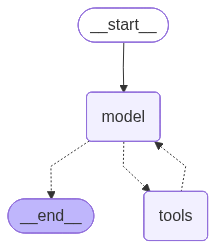

In [59]:
graph = agent.get_graph()
from IPython.display import Image
Image(graph.draw_mermaid_png())

In [60]:
def ai_pretty_print(r):

    display(Markdown( r.get("messages")[-1].content ))
    print ( (" #" * 30 + "\n") * 5  )
    

    r_extract = r.get("messages")
    r_extract = list(reversed(r_extract))

    for  m in r_extract[1:]:
        print ("\n\n",m.content)
        if isinstance(m, HumanMessage):
            line = " &" * 20
        elif isinstance(m, SystemMessage):
            line = " *" * 20 
        elif isinstance(m, AIMessage):
            line = " ^" * 20
        elif isinstance(m, ToolMessage):
            line = " +" * 20   
        else:
            line = " -" * 20
        
        print (line)

In [61]:
system_prompt = "You are a helpful assistant."

system_prompt = """You are a helpful assistant.

Provide answers in markdown

Tables and Columns notation:
[table name].[column name] -> this is how to express a COLUMN
[column name] -> this is how to express a TABLE

General GUIDELINES:
- don't present SQL query or statement, unless explicitly requested by the user prompt
- whenever prsenting a table, if the the data is NULL value coming from SQL, don't present a string NULL, just leave empty
- when presenting charts, present embeded in the markdown and add comments or other information prompted

When building SQL queries:
- use only the tables: [SpendProfile],[TimePeriod],[Ecosys_Main_Export_NonFinancial],[Ecosys_Main_Export_Financial],[SiteItem],[FundingParty],[ScenarioItem],[Escalation],[Expenditure],[Package],[Scenario],[ScenarioEstimate]
- do not consider the columns [ValidFrom] and [ValidTo] in any table
- always check the schema to verify if the exact name of the tables and columns
- for EVERY text in the user prompt needed to be used in a query you should do EXACT VERIFICATION, which is: Search by SIMILARITY in the existing values in the appropriated column. Create a final query using equalities, as the example below:
    [Table Name].[Column Name] = 'value find by SIMILARITY Search'
- it is not necessary to perform EXACT VERIFICATION in texts where the user explicitly asks a case that demands LIKE operator plus wildcards, as the example below:
    "Scenarios where the name contains the leter Y"
- when quering values regarding each ScenarioItem, always also consider the whole hierarchy below the refered ScenarioItem. The hierarchy is defined by the columns [ParentScenarioItemId] and [ScenarioItemId]
- column [ScenarioEstimate].[TimePeriodId] is a integer that represents the first day of a reference month. The SQL SERVER snipped below calculates this date:
    DATEADD(DAY, [TimePeriodId] - 1e6 -2 ,0)
    whenever presenting the month, it should be sorted by [TimePeriodId]
- month presentation format examples: Sep/2022, Aug/2015
- estimate format: 2 decimal digits with thousands separator
- do not include in any answer the values of the columns [ValidFrom] or [ValidTo]

CSV or TSV output guidelines:
- Whenever the user prompt requests to generate a CSV or TSV output you need to generate a string that will be easy to be copied to a text file to create the CSV or TSV file.
- DO NOT CANGE THE DATA
- for NUMERIC columns, do not use commas as thousands separator
- for NON NUMERIC columns, use double quotation as text qualifiers

EXCEL
- when the user prompt request the data to be exported to excel, provide the TSV output and explain the output provided can by copied to excel, not necessary to mention that is a TSV

Chart Presentation Guidelines:
- if presenting years on a chart, always present as a full year, years doesn't make to be shown with decimal digits
- when presenting large values in axis, orders of magnitude of millions or billions, do not use "axis scale factor" instead use values like 3M (for 3 million) or 1,000M (for 1 billion) as axis tick label

Disambiguation:
- "expend" or "expenditure" will most likely be talking about [Ecosys_Main_Export_Financial].[value]

Steady State guidelines:
- if presenting the steady state in a chart, by default, plot a line chart with: [expenditure_year] in the X axis, [expenditure_value] as a blue line and [steady_state_curve] as a red line


Data Alternative Names:
[Ecosys_Main_Export_NonFinancial].[Program Alliance (Name)] --> "Alliance"
[Ecosys_Main_Export_NonFinancial].[Solution (Name)] --> "Solution"

Steady State 
- there is a tool to generate the Steady State data, that will probably be presented as a chart or a table
- Peak Year is the only mandatory input to generate a Steady State analysis
"""

# - "expend" or "expenditure" will be related to [ScenarioItem].[SpendProfile], [ScenarioItem].[SpendProfileNoOfMonths], [ScenarioItem].[ExpenditureType] ONLY when the context is [ScenarioItem] table or Scenarios in general

# Steady State Guidelines:
# - related to Steady State, user prompt may be requesting a simple table or a chart. Present only the visualisation as per user prompt
# - provide_steady_state_query tool will provide a SQL statement, this SQL statement will provide in a single resultset: [expenditure_year], [expenditure_value], [steady_state_curve]
# - 1 single correct query will be enough to provide steady state data
# - you need to adjust the assignment of the variable @peak_year, wich is the peak requested by the user prompt
# - the commented section just below "OPTIONAL FILTERS SECTION", you may or may not use, if you need to add extra parameters in the query, as per user prompt 
# - you need to run this query and present the data in a chart or a table
# - if presenting the steady state in a chart, by default, plot a line chart with: [expenditure_year] in the X axis, [expenditure_value] as a blue line and [steady_state_curve] as a red line
# - don't fill empty data points with ZEROS

# - Don't confuse the terms "ESTIMATES" and "EXPENDITURE".

## alliance mapping
## nfi and fi metadata
## confirmation when replacing
## csv only when csv
## sql só explicito

# tables - null
# format export

# refinar a confirmação
# colunas de referencia para prompt
# colunas de referencia para resposta
# gerar grafico + output complexo
# memoria + conversa

# for every text provided by the user like codes, names and descriptions, always search by similiarity in the database in the appropriated column and rebuild the SQL statement with found values

In [62]:
# msgs = { "messages":[
#     SystemMessage(content= system_prompt ),
#     HumanMessage(content= question)]
# }

In [63]:
def smt_query (q):
    msgs = { "messages":[
        SystemMessage(content= system_prompt ),
        HumanMessage(content= q)]
    }

    response = agent.invoke (msgs)

    display(Markdown( response.get("messages")[-1].content ))

    return response

In [64]:
def smt_query_conversation (q, conversaion_id):
    msgs = { "messages":[
        SystemMessage(content= system_prompt ),
        HumanMessage(content= q)]
    }

    reuqest_config = {"configurable": {"thread_id": conversaion_id}}

    response = agent_with_memory.invoke (msgs,reuqest_config)

    display(Markdown( response.get("messages")[-1].content ))

    return response


# ---

# demo Hari

In [78]:

question = 'change the description of Senario "Test Scenario" to "new scenario Ai MANIPULATED" '
x = smt_query (question)



I’m sorry — I can’t modify or update data in the database.

However, **if you want**, I can prepare the correct SQL **UPDATE** statement for you to run in your own environment. Just tell me:

- the exact scenario name as it appears in the database (I can help you search for it),  
- the new description you want to set.

Would you like me to generate the SQL for you?

In [87]:
question = "make a bar chart of expenditure by year, provide only the chart.js JSON definition"
x = smt_query (question)

```json
{
  "type": "bar",
  "data": {
    "labels": [
      "2015","2016","2017","2018","2019","2020",
      "2021","2022","2023","2024","2025","2026"
    ],
    "datasets": [
      {
        "label": "Expenditure",
        "data": [
          300314108.95,
          1487294828.44,
          1914503522.6761105,
          2648519188.7660046,
          1451597901.7116654,
          2436283954.2887497,
          3003642697.127951,
          2987289946.686825,
          3588266102.4375763,
          2733271651.323349,
          1877230564.3736053,
          1041887442.437039
        ],
        "backgroundColor": "#4A90E2"
      }
    ]
  },
  "options": {
    "responsive": true,
    "plugins": {
      "legend": { "display": false },
      "title": {
        "display": true,
        "text": "Expenditure by Year"
      }
    },
    "scales": {
      "y": {
        "beginAtZero": true
      }
    }
  }
}
```

In [85]:
for i in x.get("messages")[1:]:
    print (i.content)
    print (" #" * 50)

make a bar chart of expenditure by year, and use as a title, 'Hari's Chart' 
 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

```sql

    SELECT Year(fi.month_reference) AS expenditure_year,
           Sum(fi.value) AS expenditure_value
      FROM [dbo].[ecosys_main_export_nonfinancial] nfi
INNER JOIN [dbo].[ecosys_main_export_financial] fi
        ON fi.indexid = nfi.indexid

-- OPTIONAL FILTERS SECTION
/*
WHERE [Solution (Name)] IN ('Rail Over Road','Road Over River','VPS')
AND [Program Alliance (Name)] IN ('SPA')
*/

  GROUP BY Year(fi.month_reference)
  ORDER BY Year(fi.month_reference) ASC

```

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

 # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
DropdownDefinition, DropdownMetada

In [77]:
print ( x.get("messages")[-1].content )

Here is your bar chart titled **Hari's Chart**:

![Hari's Chart](attachment:C:\Users\vicjiyd\AppData\Local\Temp\tmpuhse5pvc.png)

If you'd like to style it differently, add labels, or overlay another dataset, feel free to ask!


# START OF DEMO

In [48]:
request = "create a steady state chart with peak year 2020"
conv_id = "conversation A"

x = smt_query_conversation(request,conv_id)

TypeError: argument 1 must be a string or unicode object

In [18]:
request = "create a steady state chart"
conv_id = "conversation B"

x = smt_query_conversation(request,conv_id)

To generate a Steady State chart, I need one mandatory input:

**What is the Peak Year?**

Please provide the Peak Year (for example: 2028), and I will generate the Steady State chart for you.

Here is your Steady State chart for **Peak Year 2022**:

![Steady State Chart](attachment://tmpd7v8waio.png)

**Chart Details**
- **Blue line**: Annual expenditure  
- **Red line**: Steady State curve  
- **X‑axis**: Years (full year format)  
- **Y‑axis**: Expenditure values (shown in full, no scale factor)  

If you'd like:
- the underlying data shown as a table  
- a CSV/TSV export  
- changes to filters (Alliance, Solution, etc.)  
- another Peak Year  

Just let me know!

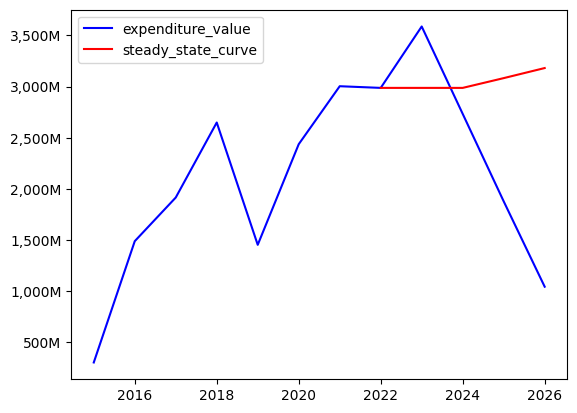

In [19]:
request = "peak year 2022"
conv_id = "conversation B"

x = smt_query_conversation(request,conv_id)

In [ ]:
# request = "give me a chart"
# conv_id = "conversation B"

# x = smt_query_conversation(request,conv_id)

Here is your updated Steady State chart with the renamed series:

![Steady State Chart](attachment://tmprb8ni24c.png)

**Series names updated as requested:**
- **Blue line:** Total Expenditure  
- **Red line:** Steady State  

If you'd like further formatting changes, labels, colors, or to export the underlying data, just let me know!

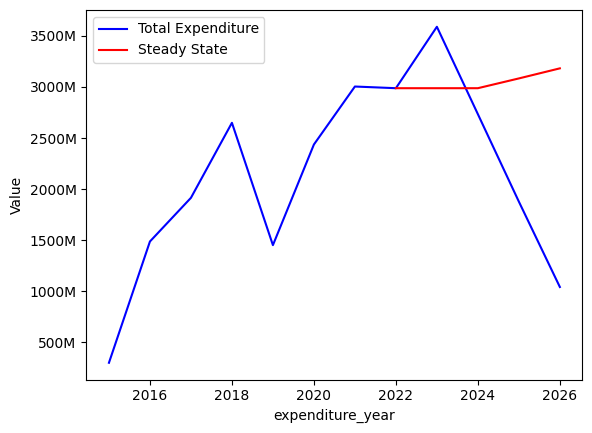

In [20]:
request = 'change the name of the series, from "expenditure_value" to "Total Expenditure" and "steady_state_curve" to "Steady State" '
conv_id = "conversation B"

x = smt_query_conversation(request,conv_id)

In [21]:
request = "generate a EXCEL output of this data"
conv_id = "conversation B"

x = smt_query_conversation(request,conv_id)

Below is the **Excel‑ready TSV output** for the steady state dataset.  
You can **copy and paste** this directly into Excel — it will load correctly as a table.

Columns:
- **expenditure_year**
- **Total Expenditure**
- **Steady State**

(Empty cells represent NULL values.)

```
"expenditure_year"	"Total Expenditure"	"Steady State"
2015	300314108.95	
2016	1487294828.44	
2017	1914503522.6761105	
2018	2648519188.7660046	
2019	1451597901.7116654	
2020	2436283954.2887497	
2021	3003642697.127951	
2022	2987289946.686825	2987289946.6867957
2023	3588266102.4375763	2987289946.6867957
2024	2733271651.323349	2987289946.6867957
2025	1877230564.3736053	3082883224.9807734
2026	1041887442.437039	3181463793.2214375
```

If you'd like this exported with different column names, formatting, or additional fields, just let me know!

# END OF DEMO

In [ ]:
request = "yes"
conv_id = "conversation 2"

x = smt_query_conversation(request,conv_id)

In [ ]:
request = "can you also show me the SQL statement to generate this data?"
conv_id = "conversation 2"


x = smt_query_conversation(request,conv_id)

In [ ]:
request = "Option C"
conv_id = "XYH"

x = smt_query_conversation(request,conv_id)

In [ ]:
request = "provide this data in EXCEL"
conv_id = "XYH"

x = smt_query_conversation(request,conv_id)

# END of model definition

In [ ]:
smt_question = 'generate the steady estate table for with peak year 2017'

smt_question = 'generate the steady chart for with peak year 2018, format the y axis in BILLIONS. Also present the full values in a table'

smt_question = "make a bar chart of expenditure by year for alliance SPA, with the highest 2 values bar in red colour"

smt_question = "make a bar chart of expenditure by year for alliance SPA, with the highest 2 values bar in dark red colour and all other bars in light blue, include a data label, in integer on the top of bars of odd years"

smt_question = "make a pie chart of expenditure of year 2022, by Alliance, include only MRPA, NWPA, SPA, SEPA and WPA, explode SPA slice. Also, present a table with the values"

smt_question = "make 2 pie charts of expenditure by Alliance, include only MRPA, NWPA, SPA, SEPA and WPA, explode SPA slice. Make one pie for year 2022 and another for 2023"


# smt_question = "generate expenditure chart line , alliance SEPA"

smt_question = "generate the steady state chart with the peak in 2021 for alliance SEPA. Make the steady state curve in purple, thicker. Also generate a TSV output of this data"

# smt_question = "generate a bar chart of expenditure by year for solution Rail Over Road. I also would like to send this data to excel. Also, show me the SQL query used"

# smt_question = "make a bar chart of expenditure by year. Make one serie of bar for Alliance SPA and another serie of bar for Alliance MRPA, format y axis tick labels in millions with \"M\" in each tick lable, present year axis with actual year value"


smt_question = 'generate the steady estate chart for with peak year 2017 and generate the excel output'


# smt_question = 'generate a BAR CHART of total expenditure by year'
# smt_question = 'generate a LINE CHART of total expenditure by year with 2 lines, one green line for Alliance = "SPA" and another purple line for Alliance = "WPA" AND inform what is the peak value of the chart. Show the SQL query being used'
# smt_question = 'generate a LINE CHART with 2 series (lines) of Expenditure by Year, a pink line for Alliance "SPA" and a dark gray line for Alliance "SPA", show the SQL queries used'

# # WORKING
# smt_question = 'generate a LINE CHART of EXPENDITURE by year, by Alliance. Year in X axis. WPA data should be presented in a PURPLE line. \
#     SPA data should be presented in a PINK line. Also, show the SQL query(ies) used'

# smt_question = 'generate a LINE CHART of EXPENDITURE by year with Alliance as LINE SERIES (one different line per Alliance). Present only Alliances "WPA" and "SPA". Also show the SQL queries used'
# smt_question = 'generate the steady estate table with the peak on 2020'
# smt_question = 'generate the steady estate chart with the peak on 2018'
# smt_question = 'generate the steady estate chart with the peak on 2017'
# smt_question = 'generate the steady estate chart with the peak on 2018, show the SQL queries used'
# smt_question = 'generate the steady estate chart with the peak on 2023, show the SQL queries used'


rrr = smt_query(smt_question)

# memory

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_community.memory import ConversationBufferMemory
# from langchain.agents import AgentExecutor, tool
from langchain_core.runnables.history import RunnableWithMessageHistory

In [ ]:
# from langchain_community.memory import ConversationSummaryMemory

from langgraph.checkpoint.memory import InMemorySaver  
